Complete Text Mining and Classification Pipeline for Fake News Detection
Module: LD7185 - Programming for AI

This script covers:
1. Data loading and exploration
2. Text preprocessing
3. Feature extraction (TF-IDF)
4. Rule-based classification
5. Machine learning models (Naive Bayes, Logistic Regression, Random Forest)
6. Model evaluation and visualization

Author: Okoh Collins
Date: December 2025

In [8]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install seaborn
!python -m pip install nltk
!python -m pip install re
!python -m pip install scikit-learn
!python -m pip install wordcloud

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [60]:
# ============================================================================
# SECTION 1: IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine learning models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, confusion_matrix, classification_report,
                            roc_auc_score, roc_curve)

# Visualization
from wordcloud import WordCloud

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')

print("All libraries imported successfully!")


All libraries imported successfully!


In [61]:
#load dataset
real = pd.read_csv("news/True.csv")
fake = pd.read_csv("news/Fake.csv")

#check for missing values
print("Missing Values real:")
print(real.isnull().sum())
print("\nMissing Values fake:")
print(fake.isnull().sum())

real['label'] = 1
fake['label'] = 0

df = pd.concat([real, fake]).sample(frac=1).reset_index(drop=True)
df.head(100)


Missing Values real:
title      0
text       0
subject    0
date       0
dtype: int64

Missing Values fake:
title      0
text       0
subject    0
date       0
dtype: int64


,title,text,subject,date,label
0,Renegade colonel surrenders in eastern Congo a...,"GOMA, Democratic Republic of Congo (Reuters) -...",worldnews,"November 5, 2017",1
1,Chinese State Media Calls Trump Out After He ...,Donald Trump has been poking China with a prov...,News,"December 12, 2016",0
2,"DISGUSTING: Daughter, 5 Cruz Supporters Drag 9...",This woman is an icon in the conservative move...,politics,"Apr 27, 2016",0
3,U.S. report on civilian drone casualties expec...,WASHINGTON (Reuters) - A U.S. report on the nu...,politicsNews,"July 1, 2016",1
4,Indiana Governor Pence says he will back Cruz ...,WASHINGTON (Reuters) - Indiana Governor Mike P...,politicsNews,"April 29, 2016",1
...,...,...,...,...,...
95,"U.S. has lost trust in South Sudan, Trump envo...",JUBA (Reuters) - The United States has lost tr...,worldnews,"October 24, 2017",1
96,In His Own Words: STUNNING Unofficial TRUMP AD...,Wow! America is hungry for a real leader. Amer...,Government News,"Aug 28, 2016",0
97,BINGO! Judge Napolitano: New Emails Found on W...,More evidence is mounting against Hillary Clin...,politics,"Oct 18, 2017",0
98,Did Donald Trump Jr. Just Say His Dad Beat Hi...,It s hard to imagine Donald Trump showing anyt...,News,"April 20, 2016",0


C:\Users\DHAVID\AppData\Local\Temp\ipykernel_1576\2262454357.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=counts.index, y=counts.values, palette=['#2ecc71', '#e74c3c'])


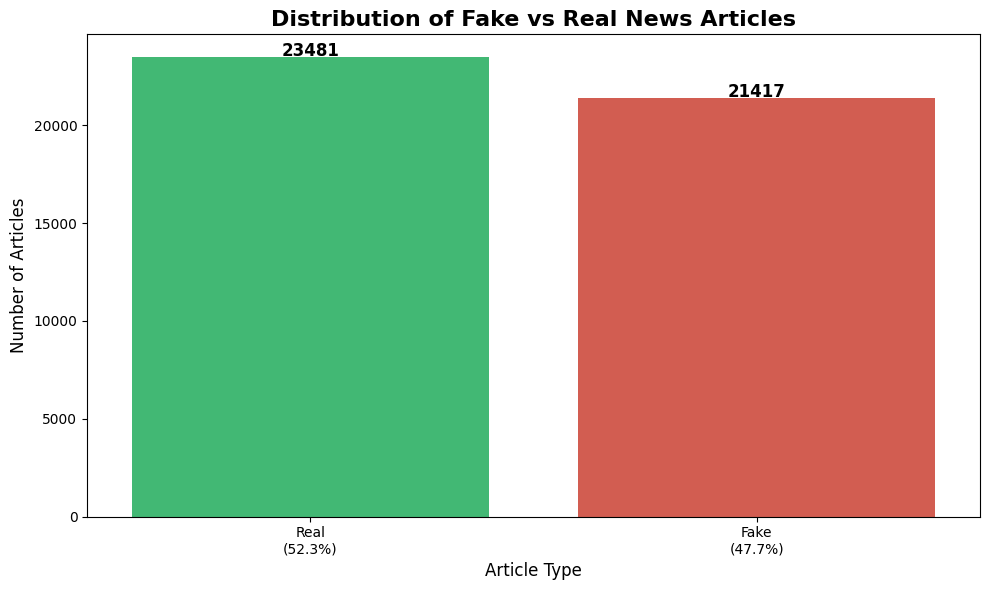

Total articles: 44898
Real news: 23481 (52.3%)
Fake news: 21417 (47.7%)
--------------------------------------------------


In [62]:
label_column = "label"
plt.figure(figsize=(10, 6))

# Count values
counts = df[label_column].value_counts()

# Create bar plot
ax = sns.barplot(x=counts.index, y=counts.values, palette=['#2ecc71', '#e74c3c'])

# Customize
plt.title('Distribution of Fake vs Real News Articles', fontsize=16, fontweight='bold')
plt.xlabel('Article Type', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)

# Add value labels on bar
for i, v in enumerate(counts.values):
    ax.text(i, v + 50, str(v), ha='center', fontsize=12, fontweight='bold')

# Add percentage
total = counts.sum()
percentages = (counts / total * 100).round(1)
plt.xticks([0, 1], [f'Real\n({percentages[0]}%)', f'Fake\n({percentages[1]}%)'])

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total articles: {total}")
print(f"Real news: {counts[0]} ({percentages[0]}%)")
print(f"Fake news: {counts[1]} ({percentages[1]}%)")
print("-" * 50)

In [63]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)
df.head()

,title,text,subject,date,label,clean_text
0,Renegade colonel surrenders in eastern Congo a...,"GOMA, Democratic Republic of Congo (Reuters) -...",worldnews,"November 5, 2017",1,goma democratic republic congo reuters clash c...
1,Chinese State Media Calls Trump Out After He ...,Donald Trump has been poking China with a prov...,News,"December 12, 2016",0,donald trump poking china proverbial stick pro...
2,"DISGUSTING: Daughter, 5 Cruz Supporters Drag 9...",This woman is an icon in the conservative move...,politics,"Apr 27, 2016",0,woman icon conservative movement spoke behalf ...
3,U.S. report on civilian drone casualties expec...,WASHINGTON (Reuters) - A U.S. report on the nu...,politicsNews,"July 1, 2016",1,washington reuters u report number civilian ca...
4,Indiana Governor Pence says he will back Cruz ...,WASHINGTON (Reuters) - Indiana Governor Mike P...,politicsNews,"April 29, 2016",1,washington reuters indiana governor mike penny...


In [65]:
fake_keywords = ['shocking', 'unbelievable', 'amazing', 'incredible', 'breaking', 'urgent', 'hoax'] 
real_keywords = ['according to', 'research', 'confirmed', 'officials', 'statement'] 

# Compile patterns for efficiency
fake_pattern = re.compile('|'.join(fake_keywords), re.IGNORECASE)
real_pattern = re.compile('|'.join(real_keywords), re.IGNORECASE)

def rule_based_classifier(texts):
    # Find all matches in the text
    fake_matches = len(re.findall(fake_pattern, texts))
    real_matches = len(re.findall(real_pattern, texts))
    
    # Logic: If more fake markers are found than real markers, label it 0 (Fake)
    if fake_matches > real_matches:
        return 0
    else:
        return 1
rule_based_classifier('shocking')
df['rule_prediction'] = df['clean_text'].apply(rule_based_classifier)

# 2. View the first few rows to see the manual guess vs the actual label
print(df[['clean_text', 'label', 'rule_prediction']].head())

# 3. Calculate the accuracy of your 'if-statement' logic
from sklearn.metrics import accuracy_score
rule_accuracy = accuracy_score(df['label'], df['rule_prediction'])
print(f"Rule-Based Model Accuracy: {rule_accuracy:.2%}")

                                          clean_text  label  rule_prediction
0  goma democratic republic congo reuters clash c...      1                1
1  donald trump poking china proverbial stick pro...      0                1
2  woman icon conservative movement spoke behalf ...      0                1
3  washington reuters u report number civilian ca...      1                1
4  washington reuters indiana governor mike penny...      1                1
Rule-Based Model Accuracy: 50.47%


In [25]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['label']
print(X)
print(y)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5711712 stored elements and shape (44898, 5000)>
  Coords	Values
  (0, 597)	0.2800509852338045
  (0, 3800)	0.04899596436497056
  (0, 1910)	0.1289932976977157
  (0, 729)	0.14175634629661837
  (0, 197)	0.14250107349850777
  (0, 2824)	0.14308196394791275
  (0, 3900)	0.14931069313158404
  (0, 4534)	0.08077425797041808
  (0, 466)	0.12104653953497593
  (0, 1939)	0.25253821034857
  (0, 728)	0.2268342194057475
  (0, 3001)	0.08179442289248087
  (0, 3282)	0.31345268402966076
  (0, 569)	0.2901137345117662
  (0, 2982)	0.12487580870656807
  (0, 1035)	0.0606186002687829
  (0, 455)	0.23552929917782084
  (0, 3462)	0.12603523642529993
  (0, 2711)	0.13623169653867317
  (0, 3667)	0.12400375224562912
  (0, 1610)	0.15036429623088615
  (0, 1967)	0.09468599554971886
  (0, 582)	0.12013667219923013
  (0, 3106)	0.09913819395435967
  (0, 3551)	0.08771947380010618
  :	:
  (44896, 1825)	0.14218567209223731
  (44896, 4935)	0.13036857524586482
  (44896, 2

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)

pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4712
           1       0.98      0.99      0.99      4268

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

pred = model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      4712
           1       0.93      0.92      0.92      4268

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_model = SVC(max_iter=5000)

svm_model.fit(X_train, y_train)

pred = svm_model.predict(X_test)
print(classification_report(y_test, pred))

C:\Users\DHAVID\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\svm\_base.py:313: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4712
           1       0.99      0.99      0.99      4268

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



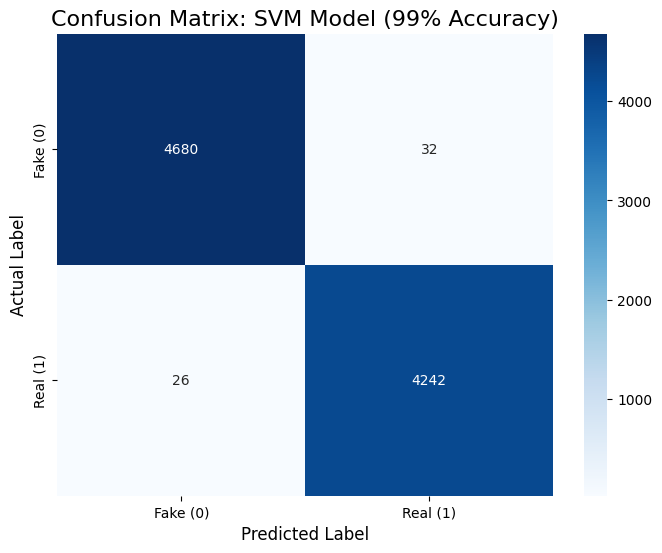

In [39]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred) 

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake (0)', 'Real (1)'], 
            yticklabels=['Fake (0)', 'Real (1)'])
plt.title('Confusion Matrix: SVM Model (99% Accuracy)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.show()

C:\Users\DHAVID\AppData\Local\Temp\ipykernel_1576\1256095992.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


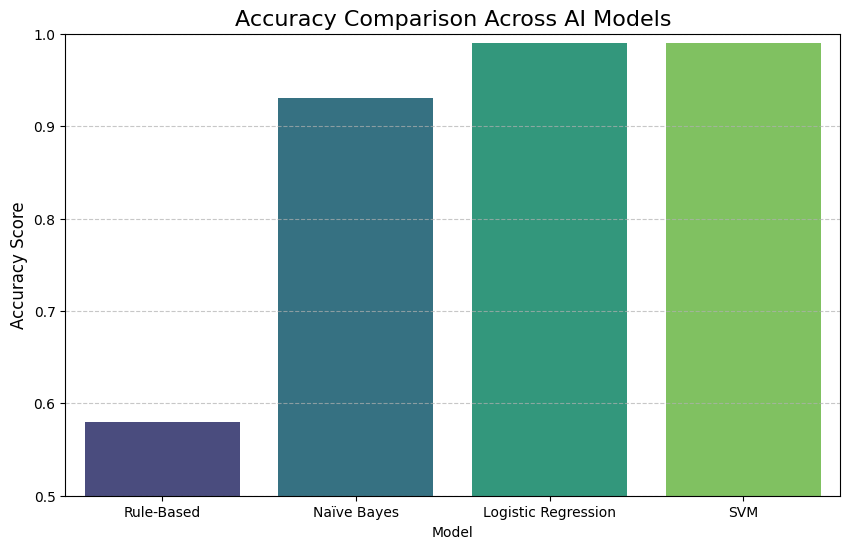

In [44]:


# Creating a summary table for your results
results = {
    'Model': ['Rule-Based', 'Naïve Bayes', 'Logistic Regression', 'SVM'],
    'Accuracy': [0.58, 0.93, 0.99, 0.99] # Adjust based on your exact results
}

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.ylim(0.5, 1.0) # Zoom in to see the differences clearly
plt.title('Accuracy Comparison Across AI Models', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [67]:
from wordcloud import WordCloud
fake = pd.read_csv("news/Fake.csv")
# Generating Word Cloud for Fake News
# 'fake_text_combined' should be a single string of all text labeled as 0
fake_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                           colormap='Reds').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords in Fake News (Class 0)', fontsize=20)
plt.show()

TypeError: expected string or bytes-like object, got 'tuple'

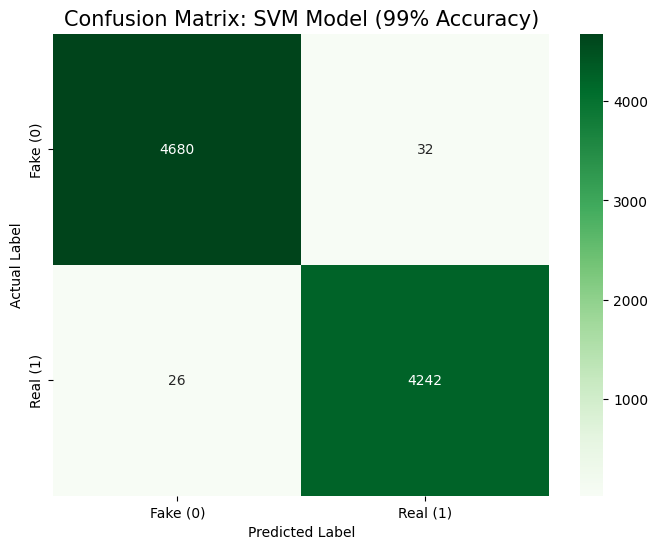

KeyError: 'clean_text'

In [52]:

from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud

# --- 1. Confusion Matrix ---
# Replace 'y_test' and 'y_pred_svm' with your actual variables
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Fake (0)', 'Real (1)'], 
            yticklabels=['Fake (0)', 'Real (1)'])
plt.title('Confusion Matrix: SVM Model (99% Accuracy)', fontsize=15)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 2. Word Cloud for Fake News (Class 0) ---
# Combine all text labeled 0 into one large string
fake_text = " ".join(df[df['label']==0]['clean_text'].astype(str))
fake_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Common Terms in Fake News', fontsize=18)
plt.show()